# NN Train on MNIST digits

In [138]:
import math
import random
import numpy as np
import time
import keras
from tqdm import trange
from IPython.display import clear_output

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [161]:
# set default print to 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [162]:
IMAGE_SIZE_X = 28
IMAGE_SIZE_Y = 28
IMAGE_SIZE = IMAGE_SIZE_X * IMAGE_SIZE_Y
LABELS_SIZE = 10


In [163]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [164]:
def compute_loss(labels, outputs):
    m = labels.shape[0]
    return -(1/m) * ( np.sum( np.multiply(np.log(outputs),labels)) + 
                      np.sum( np.multiply(np.log(1-outputs),(1-labels))))

# Example simple NN for MNIST digits only using numpy (and keras to load data)
https://towardsdatascience.com/building-an-artificial-neural-network-using-pure-numpy-3fe21acc5815

In [165]:
# Display a 28x28 digit image
def print_digit(digit):
    test_digit = np.mat(digit).reshape(28,28)
    plt.imshow(test_digit, cmap='gray')
    plt.show()

In [166]:
def load_dataset(flatten=False):
    """
    Returns:
    images_train - training data     60000x784
    labels_train - training labels   60000x1
    images_test  - test data         10000x784
    labels_test  - test labels       10000x1
    
    The source data loaded via keras holds the images as 28x28 - the 'flatten' arg
    will convert this to 784x1.

    images_train is initially 60000x28x28, and images_test is 10000x28x28
    
    The images are 'flattened' to 784x1, and also the pixels are normalized from 
    0..255 to 0..1
    """
    # Use keras library to load MNIST data from interweb
    (images_train, labels_train), (images_test, labels_test) = keras.datasets.mnist.load_data()
    print("Loaded training images", images_train.shape)
    print("Loaded test images", images_test.shape)

    # normalize input pixel values int 0..255 to float 0..1
    images_train = images_train.astype(float) / 255.
    images_test = images_test.astype(float) / 255.

    if flatten:
        images_train = images_train.reshape([images_train.shape[0], -1])
        images_test = images_test.reshape([images_test.shape[0], -1])

    return (images_train, labels_train), (images_test, labels_test)

### Display first few images (train, validate, test)

In [167]:
def print_load_data():
    print("training images:{} labels:{}, test images:{} labels:{}"
      .format(images_train.shape, labels_train.shape, images_test.shape, labels_test.shape))
    
    fig, axs = plt.subplots(2,4, figsize=(10,5))
    plt.subplots_adjust(wspace=0.3,hspace=0.6)
    fig.suptitle('Training and Test images 0..3')
    for i in range(4):
    # create subplot rows,cols,index (index starts at 1)
        axs[0,i].imshow(images_train[i].reshape([28,28]),cmap='gray',aspect='auto')
        axs[0,i].set_title("Label: {label}".format(label=labels_train[i]))
        axs[1,i].imshow(images_test[i].reshape([28,28]),cmap='gray', aspect='auto')
        axs[1,i].set_title("Label: {label}".format(label=labels_test[i]))


## NN Definition Functions

In [168]:
class Dense:
    # has properties:
    # .learning_rate (number)
    # .weights
    # .biases
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use Xavier initialization
        # https://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
        # https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79
        self.weights = np.random.normal(loc=0.0, 
                                        scale=math.sqrt(2/input_units), 
                                        size=(input_units,output_units)
                                       )
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        return np.matmul(input, self.weights) + self.biases
      
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output,np.transpose(self.weights))

        # compute gradient w.r.t. weights and biases
        grad_weights = np.transpose(np.dot(np.transpose(grad_output),input))
        grad_biases = np.sum(grad_output, axis = 0)
        
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        return grad_input

In [169]:
class ReLU:
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(0,input)

    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0 # relu_grad is now 0 (false) or 1 (true) for each element of input
        return grad_output * relu_grad 

In [170]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

In [171]:
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]
  

In [172]:
def forward(network, images):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    depth = len(network)
    activations = []
    # start with the input images as the 'activations'
    input_values = images
    
    # now iterate through the layers passing outputs into inputs
    for layer in network:
        layer_activations = layer.forward(input_values)
        activations.append(layer_activations)
        input_values = layer_activations
    
    # check we have got activations values for all layers
    assert len(activations) == depth
    # return the complete stack of activation values for entire network 
    return activations

In [173]:
def predict(network,X):
    """
    Compute network predictions.
    """
    # logits is the output of the last layer in network
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

In [174]:
def train(network,image_batch,label_batch):
    """
    Train your network on a given batch of images and labels.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # The 'depth' of the neural network is simply how many layers we have,
    # hence the term "deep neural network"
    depth = len(network)
    
    # FORWARD PASS
    # Get the layer activations
    layer_activations = forward(network,image_batch)
    
    # logits is the output (i.e. 'activation') of the final layer
    logits = layer_activations[-1]
    
    # COMPUTE ERROR (i.e. loss)
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,label_batch)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,label_batch)
    
    # BACKWARD PASS
    for i in range(1, depth):
        loss_grad = network[depth - i].backward(layer_activations[depth - i - 1], loss_grad)
    
    return np.mean(loss)
  

In [175]:
# This is a python iterator using "yield" (a bit like "return" but the procedure can later be continued)
def iterate_batches(images, labels, batchsize, shuffle=False):
    image_count = len(images)
    assert image_count == len(labels)
    
    # if 'shuffle=True' create a new array 'random_indices' with randomized indexes into images array
    if shuffle:
        random_indices = np.random.permutation(image_count)

    # batch_start starts at 0, is incremented by 'batch_size', up to start of last full batch in images
    # Note use of 'trange' means tqdm progress bar module is used
    for batch_start in trange(0, image_count-batchsize+1, batchsize):
        # if 'shuffle=True' then get next batchsize slice from random_indices
        if shuffle:
            # this will give a slice definition as a 'batchsize' count of random indices
            batch_indices = random_indices[batch_start : batch_start+batchsize]
        # otherwise define the same batchsize slice from the actual images
        else:
            # this will give a simple batchsize contiguous slice definition from the images
            batch_indices = slice(batch_start, batch_start+batchsize)
        # now return the two matching slices of the images and labels
        yield (images[batch_indices], labels[batch_indices])
        

In [176]:
(images_train, labels_train), (images_test, labels_test) = load_dataset(flatten=True)

Loaded training images (60000, 28, 28)
Loaded test images (10000, 28, 28)


training images:(60000, 784) labels:(60000,), test images:(10000, 784) labels:(10000,)


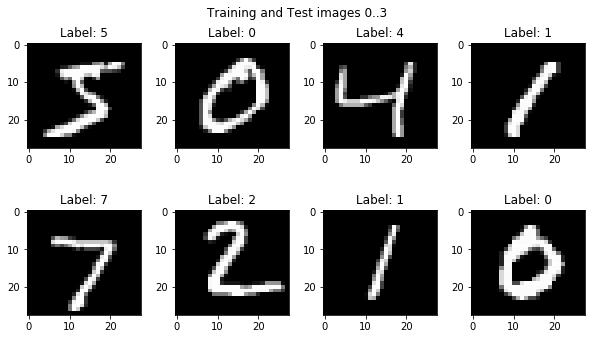

In [177]:
print_load_data()

## Create Neural Network from Layers

In [178]:
np.random.seed(66)

#nn = [ Dense(784,20), ReLU(), Dense(20,10)]

nn = [Dense(784,100), ReLU(), Dense(100,200), ReLU(), Dense(200,10)]

#network.append(Dense(images_train.shape[1],100))
#network.append(ReLU())
##network.append(Dense(100,10))
#network.append(Dense(100,200))
#network.append(ReLU())
#network.append(Dense(200,10))

## Train the network

Epoch 10
Train accuracy: 0.9533166666666667
Test accuracy: 0.9439


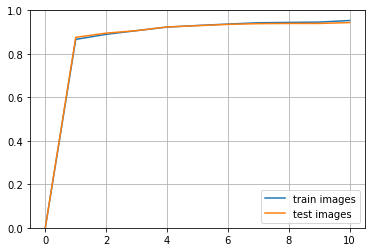

In [179]:
# number of 'epochs' is how many times we want to iterate through all the training images
epochs = 10

# train_log and test_log will be the lists of accuracy values for each epoch
train_log = [0]
test_log = [0]

for epoch in range(epochs):
    
    # Note iterate_batches uses module 'tqdm' to draw progress bar
    for (image_batch,label_batch) in iterate_batches(images_train,labels_train,batchsize=32,shuffle=True):
        train(nn,image_batch,label_batch)
    
    # Calculate ACCURACY for all the training images
    # If for every image we create an element 0|1 as bool for prediction=label
    # then the 'mean' of all those elements equates to the 'percentage' (0..1) accuracy.
    # I.e. if 10 images give [0,1,0,0,1,1,1,0,1,1] then the mean of that array is 0.6 = accuracy
    train_predict = predict(nn, images_train)
    train_accuracy = np.mean(train_predict==labels_train)
    
    # Similarly for the test images
    test_predict = predict(nn,images_test)
    test_accuracy = np.mean(test_predict==labels_test)
    
    # The rest of this just prints the accuracy/epoch graph
    clear_output()
    
    print("Epoch",epoch+1)
    print("Train accuracy:",train_accuracy)
    print("Test accuracy:",test_accuracy)
    
    train_log.append(train_accuracy)
    test_log.append(test_accuracy)
    
    plt.plot(train_log,label='train images')
    plt.plot(test_log,label='test images')
    plt.yscale('linear')
    plt.gca().set_ylim([0.0,1.0])
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Test an image

In [157]:
print(train_log)

[0, 0.8664833333333334, 0.8897833333333334, 0.90675, 0.92305, 0.9305, 0.9369666666666666, 0.94295, 0.9445, 0.946, 0.9533166666666667]


In [193]:
image_index = 0

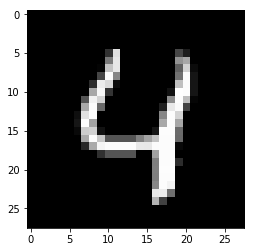

4
(1, 10)
[0.122 0.506 -3.033 -3.918 6.567 -2.430 0.607 0.431 -0.232 2.612]


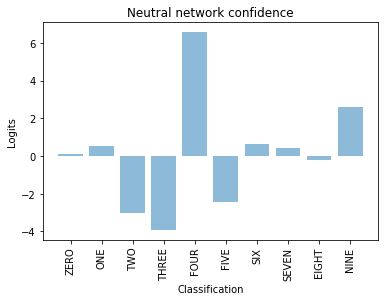

In [197]:
image_index = image_index + 1

print_digit(images_test[image_index])

layer_outputs = forward(nn,images_test[image_index:image_index+1])
print(image_index)
print(layer_outputs[-1].shape)
logits = layer_outputs[-1][0]
print(logits)
classes = ['ZERO','ONE','TWO','THREE','FOUR','FIVE','SIX','SEVEN','EIGHT','NINE']
index = np.arange(len(logits))
plt.bar(index, logits, align='center', alpha=0.5)
plt.xlabel('Classification')
plt.ylabel('Logits')
plt.xticks(index,classes,rotation=90)
plt.title('Neutral network confidence')

plt.show()

#print(forward(nn,images_test[0:1]))

In [ ]:
print(forward(images_test[8:9]))

## Draw accuracy / time plot

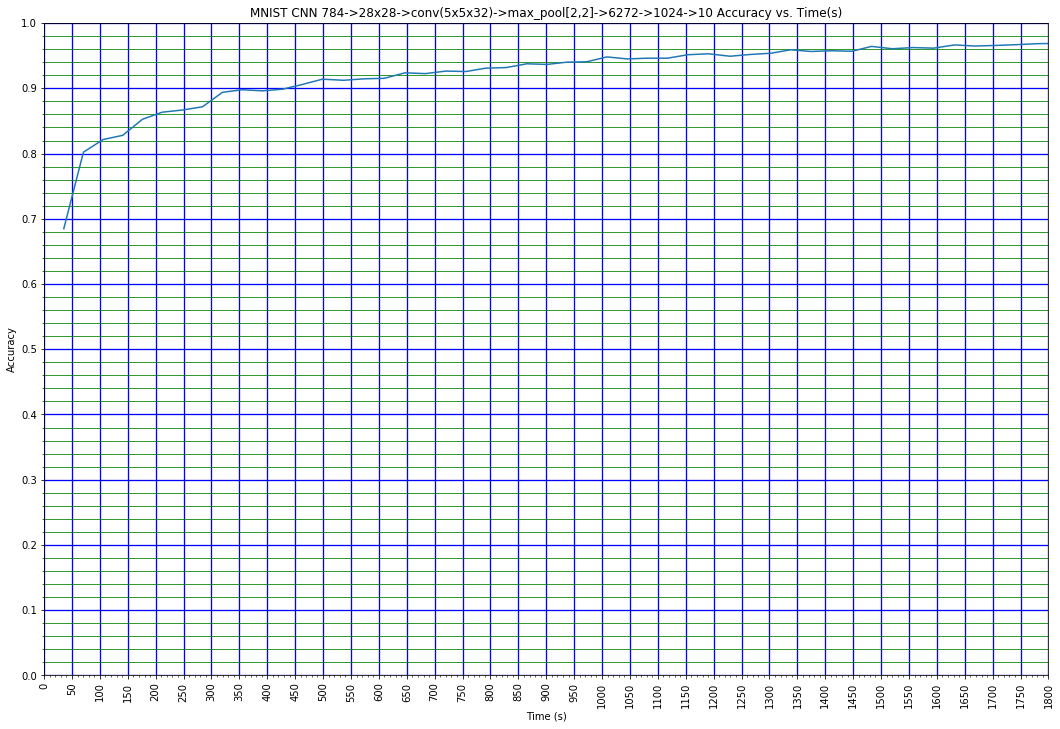

In [45]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(1, 1, 1)

ax.set_title("MNIST CNN 784->28x28->conv(5x5x32)->max_pool[2,2]->6272->1024->10 Accuracy vs. Time(s)", fontsize='large')

## Set up Time x axis

ax.set_xlabel("Time (s)")
# Min x axis value is 0 (so y-axis crosses at x=0)
ax.set_xlim(left=0)
# x ticks at 10s
ax.set_xticks(np.arange(0.0,max(graph_data_time),STEPS_COUNT))
ax.xaxis.grid(which='major', color='b', linewidth=1.3)

## Set up Accuracy y axis

ax.set_ylabel("Accuracy")
ax.set_ylim(bottom=0)
# Set Accuracy tick locations and define horizontal grid lines
minorLocator = MultipleLocator(0.05)
majorLocator = MultipleLocator(0.1)
ax.yaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.grid(which='major', color='b', linewidth=1.3)
ax.yaxis.grid(which='minor', color='g')

# Plot the chart
ax.plot(graph_data_time, graph_data_accuracy)

plt.minorticks_on()
plt.xticks(rotation=90)
plt.show(fig)